In [1]:
# import

import argparse
import scipy
import scipy.misc
from scipy import ndimage
import cv2
import easydict
import pickle
import copyreg
import types
import numpy as np
from sklearn.metrics import jaccard_similarity_score
import matplotlib.pyplot as plt

import torch
from torch.autograd import Variable
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.utils import data
from torchsummary import summary

import sys
import os
import os.path as osp
import random
import csv
import timeit
from multiprocessing import Pool 
import collections
from collections import OrderedDict

affine_par = True

#Check number of GPU's available
torch.cuda.device_count()


3

In [2]:
# global variables
input_size_list = [64, 64, 64, 256, 64, 64, 256, 64, 64, 256, 128, 128, 512, 128, 128, 512, 128, 128, 512, 128, 128, 512, 256, 256, 1024, 256, 256, 1024, 256, 256, 1024, 256, 256, 1024, 256, 256, 1024, 256, 256, 1024, 256, 256, 1024, 256, 256, 1024, 256, 256, 1024, 256, 256, 1024, 256, 256, 1024, 256, 256, 1024, 256, 256, 1024, 256, 256, 1024, 256, 256, 1024, 256, 256, 1024, 256, 256, 1024, 256, 256, 1024, 256, 256, 1024, 256, 256, 1024, 256, 256, 1024, 256, 256, 1024, 256, 256, 1024, 512, 512, 2048, 512, 512, 2048, 512, 512, 2048]

In [3]:
# Deeplab models/modules
def outS(i):
    i = int(i)
    i = (i+1)/2
    i = int(np.ceil((i+1)/2.0))
    i = (i+1)/2
    return i

def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes, affine = affine_par)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes, affine = affine_par)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, dilation=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, bias=False) # change
        self.bn1 = nn.BatchNorm2d(planes,affine = affine_par)
        for i in self.bn1.parameters():
            i.requires_grad = False

        padding = dilation
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, # change
                               padding=padding, bias=False, dilation = dilation)
        self.bn2 = nn.BatchNorm2d(planes,affine = affine_par)
        for i in self.bn2.parameters():
            i.requires_grad = False
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4, affine = affine_par)
        for i in self.bn3.parameters():
            i.requires_grad = False
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

        
    def forward(self, x):
        
        residual = x
        
        if type(x) is tuple:
            x = x[0]
            residual = x[0]

        out = self.conv1(x)
        out = self.bn1(out)
        out1 = self.relu(out)

        out = self.conv2(out1)
        out = self.bn2(out)
        out2 = self.relu(out)

        out = self.conv3(out2)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out3 = self.relu(out)

        # Grabbing intermediate activations
        activations.append(out1)
        activations.append(out2)
        activations.append(out3)
        
        return out3

class Classifier_Module(nn.Module):

    def __init__(self, dilation_series, padding_series, num_classes):
        super(Classifier_Module, self).__init__()
        self.conv2d_list = nn.ModuleList()
        for dilation, padding in zip(dilation_series, padding_series):
            self.conv2d_list.append(nn.Conv2d(2048, num_classes, kernel_size=3, stride=1, padding=padding, dilation=dilation, bias = True))

        for m in self.conv2d_list:
            m.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.conv2d_list[0](x)
        for i in range(len(self.conv2d_list)-1):
            out += self.conv2d_list[i+1](x)
        return out

class Residual_Covolution(nn.Module):
    def __init__(self, icol, ocol, num_classes):
        super(Residual_Covolution, self).__init__()
        self.conv1 = nn.Conv2d(icol, ocol, kernel_size=3, stride=1, padding=12, dilation=12, bias=True)
        self.conv2 = nn.Conv2d(ocol, num_classes, kernel_size=3, stride=1, padding=12, dilation=12, bias=True)
        self.conv3 = nn.Conv2d(num_classes, ocol, kernel_size=1, stride=1, padding=0, dilation=1, bias=True)
        self.conv4 = nn.Conv2d(ocol, icol, kernel_size=1, stride=1, padding=0, dilation=1, bias=True)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        dow1 = self.conv1(x)
        dow1 = self.relu(dow1)
        seg = self.conv2(dow1)
        inc1 = self.conv3(seg)
        add1 = dow1 + self.relu(inc1)
        inc2 = self.conv4(add1)
        out = x + self.relu(inc2)
        return out, seg

class Residual_Refinement_Module(nn.Module):

    def __init__(self, num_classes):
        super(Residual_Refinement_Module, self).__init__()
        self.RC1 = Residual_Covolution(2048, 512, num_classes)
        self.RC2 = Residual_Covolution(2048, 512, num_classes)

    def forward(self, x):
        x, seg1 = self.RC1(x)
        _, seg2 = self.RC2(x)
        return [seg1, seg1+seg2]

class ResNet_Refine(nn.Module):
    def __init__(self, block, layers, num_classes):
        self.inplanes = 64
        super(ResNet_Refine, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64, affine = affine_par)
        for i in self.bn1.parameters():
            i.requires_grad = False
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=True) # change
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=1, dilation=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=1, dilation=4)
        self.layer5 = Residual_Refinement_Module(num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, 0.01)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        #        for i in m.parameters():
        #            i.requires_grad = False

    def _make_layer(self, block, planes, blocks, stride=1, dilation=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion or dilation == 2 or dilation == 4:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion,affine = affine_par))
        for i in downsample._modules['1'].parameters():
            i.requires_grad = False
        layers = []
        layers.append(block(self.inplanes, planes, stride,dilation=dilation, downsample=downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, dilation=dilation))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)

        return x     

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64, affine = affine_par)
        for i in self.bn1.parameters():
            i.requires_grad = False
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=True) # change
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=1, dilation=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=1, dilation=4)
        self.layer5 = self._make_pred_layer(Classifier_Module, [6,12,18,24],[6,12,18,24],num_classes)
        
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, 0.01)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


    def _make_layer(self, block, planes, blocks, stride=1, dilation=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion or dilation == 2 or dilation == 4:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion,affine = affine_par))
            
        for i in downsample._modules['1'].parameters():
            i.requires_grad = False
        layers = []
        activations = []
        layers.append(block(self.inplanes, planes, stride,dilation=dilation, downsample=downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, dilation=dilation))

        return nn.Sequential(*layers)
    
    def _make_pred_layer(self,block, dilation_series, padding_series,num_classes):
        return block(dilation_series,padding_series,num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x1 = self.relu(x)
        
        # Grabbing intermediate activations
        activations.append(x1)
        
        x = self.maxpool(x1)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        return x

class MS_Deeplab(nn.Module):
    def __init__(self,block,num_classes):
        super(MS_Deeplab,self).__init__()
        self.Scale = ResNet(block,[3, 4, 23, 3],num_classes)   #changed to fix #4 

    def forward(self,x):
        output = self.Scale(x) # for original scale
        output_size = output.size()[2]
        input_size = x.size()[2]

        self.interp1 = nn.Upsample(size=(int(input_size*0.75)+1, int(input_size*0.75)+1), mode='bilinear')
        self.interp2 = nn.Upsample(size=(int(input_size*0.5)+1, int(input_size*0.5)+1), mode='bilinear')
        self.interp3 = nn.Upsample(size=(output_size, output_size), mode='bilinear')

        x75 = self.interp1(x)
        output75 = self.interp3(self.Scale(x75)) # for 0.75x scale

        x5 = self.interp2(x)
        output5 = self.interp3(self.Scale(x5))	# for 0.5x scale

        out_max = torch.max(torch.max(output, output75), output5)
        return [output, output75, output5, out_max]

def Res_Ms_Deeplab(num_classes=21):
    model = MS_Deeplab(Bottleneck, num_classes)
    return model

def Res_Deeplab(num_classes=21, is_refine=False):
    if is_refine:
        model = ResNet_Refine(Bottleneck,[3, 4, 23, 3], num_classes)
    else:
        model = ResNet(Bottleneck,[3, 4, 23, 3], num_classes)
    return model

In [4]:
# My modules
class Decoder_Multiclass_Weighting(nn.Module):
    def __init__(self, channel_size, num_classes):
        super(Decoder_Multiclass_Weighting, self).__init__()
        self.layer1 = nn.Conv2d(in_channels = channel_size, out_channels=128, kernel_size=5, stride=1, padding=0)
        
        self.bn1 = nn.BatchNorm2d(128, affine = True)
        for i in self.bn1.parameters():
            i.requires_grad = False
        self.relu1 = nn.ReLU(inplace=True)
        
        self.layer2 = nn.Conv2d(in_channels = 128 , out_channels=64, kernel_size=3, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(64, affine = True)
        for i in self.bn1.parameters():
            i.requires_grad = False
        self.relu2 = nn.ReLU(inplace=True)
        
        self.predict = nn.Conv2d(in_channels = 64, out_channels=num_classes, kernel_size=1, stride=1, padding=0)
        
        torch.nn.init.kaiming_normal_(self.layer1.weight.data)
        torch.nn.init.kaiming_normal_(self.predict.weight.data)
 
        
    def forward(self, x):
        output = self.layer1(x)
        output = self.bn1(output)
        output = self.relu1(output)
        output = self.layer2(output)
        output = self.bn2(output)
        output = self.relu2(output)
        output = self.predict(output)
        return output
    
class Decoder_Multiclass_Weighting_Deep(nn.Module):
    def __init__(self, channel_size, num_classes):
        super(Decoder_Multiclass_Weighting_Deep, self).__init__()
        self.layer1 = nn.Conv2d(in_channels = channel_size, out_channels=128, kernel_size=5, stride=1, padding=0)
        
        self.bn1 = nn.BatchNorm2d(128, affine = True)
        for i in self.bn1.parameters():
            i.requires_grad = False
        self.relu1 = nn.ReLU(inplace=True)
        
        self.layer2 = nn.Conv2d(in_channels = 128 , out_channels=64, kernel_size=3, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(64, affine = True)
        for i in self.bn2.parameters():
            i.requires_grad = False
        self.relu2 = nn.ReLU(inplace=True)
        
        self.layer3 = nn.Conv2d(in_channels = 64 , out_channels=64, kernel_size=5, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(64, affine = True)
        for i in self.bn3.parameters():
            i.requires_grad = False
        self.relu3 = nn.ReLU(inplace=True)
        
        self.layer4 = nn.Conv2d(in_channels = 64 , out_channels=32, kernel_size=3, stride=1, padding=0)
        self.bn4 = nn.BatchNorm2d(32, affine = True)
        for i in self.bn4.parameters():
            i.requires_grad = False
        self.relu4 = nn.ReLU(inplace=True)
        
        self.layer5 = nn.Conv2d(in_channels = 32 , out_channels=32, kernel_size=3, stride=1, padding=0)
        self.bn5 = nn.BatchNorm2d(32, affine = True)
        for i in self.bn5.parameters():
            i.requires_grad = False
        self.relu5 = nn.ReLU(inplace=True)
        
        self.predict = nn.Conv2d(in_channels = 32, out_channels=num_classes, kernel_size=1, stride=1, padding=0)
        
        torch.nn.init.kaiming_normal_(self.layer1.weight.data)
        torch.nn.init.kaiming_normal_(self.predict.weight.data)
 
        
    def forward(self, x):
        output = self.layer1(x)
        output = self.bn1(output)
        output = self.relu1(output)
        output = self.layer2(output)
        output = self.bn2(output)
        output = self.relu2(output)
        output = self.layer3(output)
        output = self.bn3(output)
        output = self.relu3(output)
        output = self.layer4(output)
        output = self.bn4(output)
        output = self.relu4(output)
        output = self.layer5(output)
        output = self.bn5(output)
        output = self.relu5(output)
        output = self.predict(output)
        return output
    
    
class Decoder_Binary_weighting(nn.Module):
    def __init__(self, channel_size, num_classes):
        super(Decoder_Binary_weighting, self).__init__()
        self.layer1 = nn.Conv2d(in_channels = channel_size, out_channels=128, kernel_size=5, stride=1, padding=0)
        
        self.bn1 = nn.BatchNorm2d(128, affine = True)
        for i in self.bn1.parameters():
            i.requires_grad = False
        self.relu1 = nn.ReLU(inplace=True)
        
        self.layer2 = nn.Conv2d(in_channels = 128 , out_channels=64, kernel_size=3, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(64, affine = True)
        for i in self.bn1.parameters():
            i.requires_grad = False
        self.relu2 = nn.ReLU(inplace=True)
        
        self.predict = nn.Conv2d(in_channels = 64, out_channels=num_classes, kernel_size=1, stride=1, padding=0)
        
        torch.nn.init.kaiming_normal_(self.layer1.weight.data)
        torch.nn.init.kaiming_normal_(self.predict.weight.data)

 
        
    def forward(self, x):
        output = self.layer1(x)
        output = self.bn1(output)
        output = self.relu1(output)
        output = self.layer2(output)
        output = self.bn2(output)
        output = self.relu2(output)
        output = self.predict(output)
        return output   

class Decoder_Binary(nn.Module):
    def __init__(self, channel_size):
        super(Decoder_Binary, self).__init__()
        self.layer1 = nn.Conv2d(in_channels = channel_size, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(64, affine = True)
        for i in self.bn1.parameters():
            i.requires_grad = False
        self.relu = nn.ReLU(inplace=True)
        self.predict = nn.Conv2d(in_channels = 64, out_channels=2, kernel_size=1, stride=1, padding=0)
        
        self.layer1.weight.data.normal_(0, 0.1)
        self.predict.weight.data.normal_(0, 0.1)
 
        
    def forward(self, x):
        output = self.layer1(x)
        output = self.bn1(output)
        output = self.relu(output)
        output = self.predict(output)
        return output

class Decoder_Small(nn.Module):
    def __init__(self, channel_size):
        super(Decoder_Small, self).__init__()
        self.predict = nn.Conv2d(in_channels = channel_size, out_channels=2, kernel_size=1, stride=1, padding=0)
        self.predict.weight.data.normal_(0, 0.1)
 
        
    def forward(self, x):
        output = self.predict(x)
        return output

In [5]:
# Dataset
class VOCDataSet(data.Dataset):
    def __init__(self, root, list_path, max_iters=None, crop_size=(321, 321), mean=(128, 128, 128), scale=True, mirror=True, ignore_label=255):
        self.root = root
        self.list_path = list_path
        self.crop_h, self.crop_w = crop_size
        self.scale = scale
        self.ignore_label = ignore_label
        self.mean = mean
        self.is_mirror = mirror
        # self.mean_bgr = np.array([104.00698793, 116.66876762, 122.67891434])
        self.img_ids = [i_id.strip() for i_id in open(list_path)]
        if not max_iters==None:
            self.img_ids = self.img_ids * int(np.ceil(float(max_iters)/len(self.img_ids)))
        self.files = []
        # for split in ["train", "trainval", "val"]:
        for name in self.img_ids:
            img_file   = osp.join(self.root, "JPEGImages/%s.jpg" % name)
            label_file = osp.join(self.root, "SegmentationClassAug/%s.png" % name)
            self.files.append({
                "img": img_file,
                "label": label_file,
                "name": name
            })

    def __len__(self):
        return len(self.files)

    def generate_scale_label(self, image, label):
        f_scale = 0.5 + random.randint(0, 11) / 10.0
        image = cv2.resize(image, None, fx=f_scale, fy=f_scale, interpolation = cv2.INTER_LINEAR)
        label = cv2.resize(label, None, fx=f_scale, fy=f_scale, interpolation = cv2.INTER_NEAREST)
        return image, label

    def __getitem__(self, index):
        datafiles = self.files[index]
        
        image = cv2.imread( datafiles["img"],   cv2.IMREAD_COLOR)
        label = cv2.imread(datafiles["label"], cv2.IMREAD_GRAYSCALE)

        size = image.shape
        name = datafiles["name"]
        if self.scale:
            image, label = self.generate_scale_label(image, label)
        image = np.asarray(image, np.float32)
        image -= self.mean
        img_h, img_w = label.shape
        pad_h = max(self.crop_h - img_h, 0)
        pad_w = max(self.crop_w - img_w, 0)
        
        #Changed to BORDER_REFLECT From BORDER_CONSTANT
        '''
        if pad_h > 0 or pad_w > 0:
            img_pad = cv2.copyMakeBorder(image, 0, pad_h, 0, 
                pad_w, cv2.BORDER_REFLECT, 
                value=(0.0, 0.0, 0.0))
            label_pad = cv2.copyMakeBorder(label, 0, pad_h, 0, 
                pad_w, cv2.BORDER_REFLECT,
                value=(self.ignore_label,))
        '''
        
        if pad_h > 0 or pad_w > 0:
            img_pad = cv2.copyMakeBorder(image, 0, pad_h, 0, 
                pad_w, cv2.BORDER_REFLECT, 
                value=(0.0, 0.0, 0.0))
            label_pad = cv2.copyMakeBorder(label, 0, pad_h, 0, 
                pad_w, cv2.BORDER_REFLECT,
                value=(self.ignore_label,))    
        
        else:
            img_pad, label_pad = image, label

        img_h, img_w = label_pad.shape
        
        h_off = 0
        w_off = 0
        
        image = np.asarray(img_pad[h_off : h_off+self.crop_h, w_off : w_off+self.crop_w], np.float32)
        label = np.asarray(label_pad[h_off : h_off+self.crop_h, w_off : w_off+self.crop_w], np.float32)
        
        image = image.transpose((2, 0, 1))
        if self.is_mirror:
            flip = np.random.choice(2) * 2 - 1
            image = image[:, :, ::flip]
            label = label[:, ::flip]

        return image.copy(), label.copy(), np.array(size), name

class VOCDataTestSet(data.Dataset):
    def __init__(self, root, list_path, crop_size=(505, 505), mean=(128, 128, 128)):
        self.root = root
        self.list_path = list_path
        self.crop_h, self.crop_w = crop_size
        self.mean = mean
        # self.mean_bgr = np.array([104.00698793, 116.66876762, 122.67891434])
        self.img_ids = [i_id.strip() for i_id in open(list_path)]
        self.files = [] 
        # for split in ["train", "trainval", "val"]:
        for name in self.img_ids:
            img_file = osp.join(self.root, "JPEGImages/%s.jpg" % name)
            self.files.append({
                "img": img_file
            })

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        datafiles = self.files[index]
        image = cv2.imread(datafiles["img"], cv2.IMREAD_COLOR)
        size = image.shape
        name = osp.splitext(osp.basename(datafiles["img"]))[0]
        image = np.asarray(image, np.float32)
        image -= self.mean
        
        img_h, img_w, _ = image.shape
        pad_h = max(self.crop_h - img_h, 0)
        pad_w = max(self.crop_w - img_w, 0)
        if pad_h > 0 or pad_w > 0:
            image = cv2.copyMakeBorder(image, 0, pad_h, 0, 
                pad_w, cv2.BORDER_REFLECT, 
                value=(0.0, 0.0, 0.0))
        image = image.transpose((2, 0, 1))
        return image, name, size
    
def binary_gt_convert(output, gt):
    #Class independant error
    
    binary_gt = np.where( gt > 0, 1, 0)
    binary_output = np.where( output > 0, 1, 0)
    int_gt = np.where(binary_gt-binary_output != 0, 1, 0)
    return int_gt


def class_gt_convert(output, gt):
    #Class dependant error
    
    class_diff = output - gt                     #correct values will be 0, else is error
    int_gt = np.where(class_diff != 0, 1, 0)
    return int_gt

def class_out_gt_convert(output, gt):
    #Multi-class error
    
    gt = np.where(gt == 255, 0, gt)              #GT with ignored borders
    class_diff = output - gt                     #All correct values --> Class_diff will be zero
    gt_error_mask = np.where(class_diff == 0, 0, gt)
    int_gt = gt_error_mask     
    return int_gt

In [ ]:
# Training Hyperparameters

start = timeit.default_timer()

IMG_MEAN = np.array((104.00698793,116.66876762,122.67891434), dtype=np.float32)

BATCH_SIZE = 1

# Grabs from PascalVOC Development kit structure
DATA_DIRECTORY = './data/VOCdevkit/VOC2012'#'../../data/VOCdevkit/voc12'
DATA_LIST_PATH = './dataset/list/train_aug.txt' 

IGNORE_LABEL = 255
INPUT_SIZE = '321,321'
IS_TRAINING = False

LEARNING_RATE = 2e-5

MOMENTUM = 0.9
NOT_RESTORE_LAST = False
NUM_CLASSES = 21
NUM_STEPS = 20000
POWER = 0.9
RANDOM_MIRROR = False
RANDOM_SCALE = False
RANDOM_SEED = 1234 
RESTORE_FROM = './snapshots/VOC12_scenes_20000.pth'                          # Use for training intermediate networks
#RESTORE_FROM = './dataset/MS_DeepLab_resnet_pretrained_COCO_init.pth'       # Use for training deeplabv2
SAVE_NUM_IMAGES = 2
SAVE_PRED_EVERY = 1000
SNAPSHOT_DIR = './snapshots/'
WEIGHT_DECAY = 0.0005

def get_arguments():
    
    args = easydict.EasyDict({
    "batch_size": BATCH_SIZE,
    "data_dir": DATA_DIRECTORY,
    "data_list": DATA_LIST_PATH,
    "ignore_label": IGNORE_LABEL,
    "input_size": INPUT_SIZE,
    "is_training": IS_TRAINING,
    "learning_rate": LEARNING_RATE,
    "momentum": MOMENTUM,
    "not_restore_last": NOT_RESTORE_LAST,
    "num_classes": NUM_CLASSES,
    "num_steps": NUM_STEPS,
    "power": POWER,
    "random_mirror": RANDOM_MIRROR,
    "random_scale": RANDOM_SCALE,
    "random_seed": RANDOM_SEED,
    "restore_from": RESTORE_FROM,
    "save_num_images": SAVE_NUM_IMAGES,
    "save_pred_every": SAVE_PRED_EVERY,
    "snapshot_dir": SNAPSHOT_DIR,
    "weight_decay": WEIGHT_DECAY,
    "gpu": 0
    })
    
    return args

args = get_arguments()
gpu0 = args.gpu

def loss_calc(pred, label):
    """
    This function returns cross entropy loss for semantic segmentation
    """
    # out shape batch_size x channels x h x w -> batch_size x channels x h x w
    # label shape h x w x 1 x batch_size  -> batch_size x 1 x h x w
    
    label = Variable(label.long()).cuda(gpu0)
    
    criterion = torch.nn.CrossEntropyLoss(ignore_index=IGNORE_LABEL).cuda(gpu0)
    
    return criterion(pred, label)

def loss_calc_int(pred, label):
    """
    This function returns cross entropy loss for semantic segmentation
    """
    # out shape batch_size x channels x h x w -> batch_size x channels x h x w
    # label shape h x w x 1 x batch_size  -> batch_size x 1 x h x w
    
    label = Variable(label.long()).cuda(gpu0)
    
    weights = np.asarray([ 0.85, 0.15])
    
    tensor_weights = torch.from_numpy(weights).float().cuda(gpu0)
    criterion = torch.nn.CrossEntropyLoss(weight = tensor_weights, ignore_index=IGNORE_LABEL).cuda(gpu0)
    
    return criterion(pred, label)

def weighted_cross_entropy_loss(prediction, label):   #Taken from ~~ https://github.com/meteorshowers/hed-pytorch/blob/master/functions.py ~~
    
    criterion = torch.nn.CrossEntropyLoss(reduce=False)
    
    label = Variable(label.long()).cuda(gpu0)
    nch = prediction.shape[1]
    label[label >= nch] = 0
    
    cost = criterion(prediction, label)
    
    mask = (label != 0).float()
    num_positive = torch.sum(mask).float()
    num_negative = mask.numel() - num_positive
    
    mask[mask == 1] = 0.9
    mask[mask == 0] = 0.1
    
    
    cost = torch.mul(cost, mask)

    return torch.sum(cost)

def SP_Loss_calc(new_model, old_param_list):
    new_param_list = []
    
    for param in new_model.parameters():
        new_param_list.append(param.data)
    
    param_diff = []
    count = 0
    for i in new_param_list:
        param_diff.append(i - old_param_list[count])
        count += 1

    for j in range(len(param_diff)):
        param_diff[j] = param_diff[j].norm()
        
    loss = sum(param_diff)
    return loss.item()

def multiclass_weight_loss_calc(pred, label):
    # out shape batch_size x channels x h x w -> batch_size x channels x h x w
    # label shape h x w x 1 x batch_size  -> batch_size x 1 x h x w
    
    unique, counts = np.unique(label, return_counts=True)
    label = Variable(label.long()).cuda(gpu0)

    manual_weights = np.asarray([0.85, 0.15, 0.15, 0.15 , 0.15, 0.15, 0.15, 
                      0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15,
                      0.15, 0.15, 0.15, 0.15,0.15, 0.15])
    
    tensor_weight = torch.from_numpy(manual_weights).float().cuda(gpu0)
    
    criterion = torch.nn.CrossEntropyLoss(weight = tensor_weight)
    
    return criterion(pred, label)

def lr_poly(base_lr, iter, max_iter, power):
    return base_lr*((1-float(iter)/max_iter)**(power))

def get_1x_lr_params_NOscale(model):
    """
    This generator returns all the parameters of the net except for 
    the last classification layer. Note that for each batchnorm layer, 
    requires_grad is set to False in deeplab_resnet.py, therefore this function does not return 
    any batchnorm parameter
    """
    b = []

    b.append(model.conv1)
    b.append(model.bn1)
    b.append(model.layer1)
    b.append(model.layer2)
    b.append(model.layer3)
    b.append(model.layer4)

    
    for i in range(len(b)):
        for j in b[i].modules():
            jj = 0
            for k in j.parameters():
                jj+=1
                if k.requires_grad:
                    yield k
                
def get_1x_lr_params_NOscale_int(model): 
    """
    This generator returns all the parameters of the net except for 
    the last classification layer. Note that for each batchnorm layer, 
    requires_grad is set to False in deeplab_resnet.py, therefore this function does not return 
    any batchnorm parameter
    """
    b = []

    b.append(model.layer1)
    b.append(model.bn1)
    b.append(model.predict)
    
    for i in range(len(b)):
        for j in b[i].modules():
            jj = 0
            for k in j.parameters():
                jj+=1
                if k.requires_grad:
                    yield k

def get_10x_lr_params(model):
    """
    This generator returns all the parameters for the last layer of the net,
    which does the classification of pixel into classes
    """
    b = []
    b.append(model.layer5.parameters())

    for j in range(len(b)):
        for i in b[j]:
            yield i          
            
def adjust_learning_rate(optimizer, i_iter):
    """Sets the learning rate to the initial LR divided by 5 at 60th, 120th and 160th epochs"""
    lr = lr_poly(args.learning_rate, i_iter, args.num_steps, args.power)
    optimizer.param_groups[0]['lr'] = lr
    optimizer.param_groups[1]['lr'] = lr * 10
    
def adjust_learning_rate_int(optimizer, i_iter):
    """Sets the learning rate to the initial LR divided by 5 at 60th, 120th and 160th epochs"""
    lr = lr_poly(args.learning_rate, i_iter, args.num_steps, args.power)
    optimizer.param_groups[0]['lr'] = lr 

In [ ]:
# TRAINING SUPERVISOR NETWORKS
def main():
    
    os.environ["CUDA_VISIBLE_DEVICES"]=str(args.gpu)
    h, w = map(int, args.input_size.split(','))
    input_size = (h, w)

    cudnn.enabled = True
    
    layer = 99
    
    # Create networks
    model = Res_Deeplab(num_classes=args.num_classes)
    #int_model = Decoder_Binary(input_size_list[layer])                                         #input_size_list[layer] defines input size for mid layer
    #int_model = Decoder_Multiclass_Weighting(input_size_list[layer], num_classes = NUM_CLASSES)  
    int_model = Decoder_Multiclass_Weighting_Deep(input_size_list[layer], num_classes= NUM_CLASSES)

    gpu0 = args.gpu

    saved_state_dict = torch.load('./snapshots/VOC12_scenes_20000.pth')
    
    '''
    #Loading and removing extra term infront of layer names if neccessary
    new_state_dict = OrderedDict()
    for k, v in saved_state_dict.items():
        name = k[6:] # remove `module.`
        new_state_dict[name] = v
    # load params
    model.load_state_dict(new_state_dict)
    '''
    
    
    model.load_state_dict(saved_state_dict)
    
    model.eval()
    model.cuda(gpu0)
    
    for param in model.parameters():
        param.requires_grad = False

    int_model.train()
    int_model.cuda(gpu0)
    
    cudnn.benchmark = True

    if not os.path.exists('./Int_Snapshots/'):
        os.makedirs('./Int_Snapshots/')


    trainloader = data.DataLoader(VOCDataSet(args.data_dir, args.data_list, max_iters=args.num_steps*args.batch_size, crop_size=input_size, scale=args.random_scale, mirror=args.random_mirror, mean=IMG_MEAN), 
                    batch_size=1, shuffle=True, num_workers=5, pin_memory=True)

    
    optimizer = optim.SGD(params = get_1x_lr_params_NOscale_int(int_model), lr=args.learning_rate, momentum=args.momentum,weight_decay=args.weight_decay)
    
    optimizer.zero_grad()

    interp = nn.Upsample(size=input_size, mode='bilinear', align_corners=True)


    for i_iter, batch in enumerate(trainloader):
        images, labels, size, name = batch
        
        size = size.numpy()[0]
        
        global activations
        activations = []

        images = Variable(images).cuda(gpu0)
        optimizer.zero_grad()
        adjust_learning_rate_int(optimizer, i_iter)
        output = interp(model(images)).cpu().data[0].numpy()
        
        gt = np.asarray(labels[0].numpy(), dtype=np.int)
        output = output.transpose(1,2,0)
        
        output = np.asarray(np.argmax(output, axis=2), dtype=np.int)
        

        #int_gt = binary_gt_convert(output, gt)       #Class independant binary error prediction case
        #int_gt = class_gt_convert(output, gt)        #Class dependant binary error prediction case
        int_gt = class_out_gt_convert(output, gt)     #Multi-class error prediction case
        
        #Reshaping to [1, 321, 321]
        int_gt = int_gt[np.newaxis,:,:]  
        int_gt = torch.from_numpy(int_gt)    

        int_output = interp(int_model(activations[layer]))      #Output of intermediate layer
        
        
        
        #Different loss functions for multiclass vs binary error
        loss = multiclass_weight_loss_calc(int_output, int_gt)
        #loss = weighted_cross_entropy_loss(int_output, int_gt)        
        
        loss.backward()
        optimizer.step()
          
            
        print('iter = ', i_iter, 'of', args.num_steps,'completed, loss = ', loss.data.cpu().numpy())

        if i_iter >= args.num_steps-1:
            print( 'save model ...')
            torch.save(int_model.state_dict(),osp.join('./Int_Snapshots/', 'NAME_OF_SUPERVISOR' + str(LEARNING_RATE) + str(args.num_steps)+'.pth'))
            break

        if i_iter % args.save_pred_every == 0 and i_iter!=0:
            print('taking snapshot ...')
            torch.save(int_model.state_dict(),osp.join('./Int_Snapshots/', 'NAME_OF_SUPERVISOR' + str(LEARNING_RATE) + str(i_iter)+'.pth'))

    end = timeit.default_timer()
    print(end-start,'seconds')

if __name__ == '__main__': 
     main()

In [ ]:
# TRAINING AND FINE-TUNING THE STUDENT

#Defining source model for L2-SP loss
source_model = Res_Deeplab(num_classes=args.num_classes)
source_saved_state = torch.load('./snapshots/VOC12_scenes_20000.pth')
source_model.load_state_dict(source_saved_state)  
source_model.eval()
source_model.cuda(gpu0)
old_param_list = []
    
for param in source_model.parameters():
    old_param_list.append(param.data)

def main():
    """Create the model and start the training."""
    
    os.environ["CUDA_VISIBLE_DEVICES"]=str(args.gpu)
    h, w = map(int, args.input_size.split(','))
    input_size = (h, w)

    cudnn.enabled = True
    layer = 99     #THIS DEFINES THE LAYER THAT THE SUPERVISOR GRABS ACTIVATIONS FROM
    
    # Create networks
    model = Res_Deeplab(num_classes=args.num_classes)
    
    int_model = Decoder_Binary(input_size_list[layer])
    #int_model = Decoder_Multiclass_Weighting(input_size_list[layer], num_classes = NUM_CLASSES)       #input_size_list[layer] defines input size for mid layer

    saved_state_dict = torch.load(args.restore_from)
    int_saved_state_dict = torch.load('./Int_Snapshots/Binary_Error/REFLECT_PADDING/class_dependant/class_dep_lay90_lr2.5e-0510000.pth')
    
    
    new_params = model.state_dict().copy()
    for i in saved_state_dict:
        #Scale.layer5.conv2d_list.3.weight
        i_parts = i.split('.')
        # print i_parts
        if not args.num_classes == 21 or not i_parts[1]=='layer5':
            new_params['.'.join(i_parts[1:])] = saved_state_dict[i]
            
    model.load_state_dict(saved_state_dict)                            #For training from VOC weights
    #model.load_state_dict(new_params)                                 #For training from COCO pre-trained weights
    model.train()
    model.cuda(gpu0)
    
    
    '''
    ct = 0
    for child in model.children():
        if ct < 8:
            for param in child.parameters():                 #Uncomment this to freeze certain layers of the student during the fine-tuning process
                param.requires_grad = False
        ct += 1
    '''
    
    # Create supervisor
    int_model.load_state_dict(int_saved_state_dict)
    int_model.eval()
    int_model.cuda(gpu0)
    
    
    #Freeze weights in supervisor network
    for child in int_model.children():
            for param in child.parameters():
                param.requires_grad = False
    
    cudnn.benchmark = True

    if not os.path.exists(args.snapshot_dir):
        os.makedirs(args.snapshot_dir)


    trainloader = data.DataLoader(VOCDataSet(args.data_dir, args.data_list, max_iters=args.num_steps*args.batch_size, crop_size=input_size, 
                    scale=args.random_scale, mirror=args.random_mirror, mean=IMG_MEAN), 
                    batch_size=args.batch_size, shuffle=True, num_workers=5, pin_memory=True)

    optimizer = optim.SGD([{'params': get_1x_lr_params_NOscale(model), 'lr': args.learning_rate }, 
                {'params': get_10x_lr_params(model), 'lr': 10*args.learning_rate}], 
                lr=args.learning_rate, momentum=args.momentum ,weight_decay=args.weight_decay)
    
    optimizer.zero_grad()

    interp = nn.Upsample(size=input_size, mode='bilinear', align_corners=True)

    
    for i_iter, batch in enumerate(trainloader):
        images, labels, size, name = batch
        
        size = size.numpy()[0]
        
        global activations
        activations = []

        #------------------------------------------------------------------------
        
        images = Variable(images).cuda(gpu0)
        optimizer.zero_grad()
        adjust_learning_rate(optimizer, i_iter)
        pred = interp(model(images))
        
        output = interp(model(images)).cpu().data[0].numpy()
        
        gt = np.asarray(labels[0].numpy(), dtype=np.int)
        output = pred.cpu().data[0].numpy().transpose(1,2,0)
        output = np.asarray(np.argmax(output, axis=2), dtype=np.int)
        
        
        
        # Fine tuning was only done using the binary class-dependant error
        int_gt = binary_gt_convert(output, gt)    
        
        int_gt = int_gt[np.newaxis,:,:]  
        int_gt = torch.from_numpy(int_gt)
        
        int_output = interp(int_model(activations[layer]))
        
        
        EG_reg = int_output.cpu().data[0].numpy()
        EG_reg = EG_reg[:,:size[0],:size[1]]
        EG_reg = EG_reg.transpose(1,2,0)
        EG_reg = np.asarray(np.argmax(EG_reg, axis=2), dtype=np.int)
        EG_reg = np.count_nonzero(EG_reg)/ EG_reg.size
        
        egloss_weight = 1
        alpha = 1
        
        loss1 = loss_calc(pred, labels)
                
        loss2 = egloss_weight*loss_calc_int(int_output, int_gt)
        SP_Loss = (alpha/2)*SP_Loss_calc(model, old_param_list)
        
        loss = loss1 + EG_reg + SP_Loss + loss2
        
        loss.backward()
        optimizer.step()

        
        print('iter = ', i_iter, 'of', args.num_steps,'completed, loss = ', loss.data.cpu().numpy())
        
        if i_iter >= args.num_steps-1:
            print( 'save model ...')
            torch.save(model.state_dict(),osp.join(args.snapshot_dir, 'NAME_OF_FINETUNED_MODEL' + str(LEARNING_RATE) +str(args.num_steps)+'.pth'))
            break

        if i_iter % args.save_pred_every == 0 and i_iter!=0:
            print('taking snapshot ...')
            torch.save(model.state_dict(),osp.join(args.snapshot_dir, 'NAME_OF_FINETUNED_MODEL' + str(LEARNING_RATE) +str(i_iter)+'.pth'))     

    end = timeit.default_timer()
    print(end-start,'seconds')
    
if __name__ == '__main__':
     main()


In [6]:
# Metric setup
def _pickle_method(m):
    if m.im_self is None:
        return getattr, (m.im_class, m.im_func.func_name)
    else:
        return getattr, (m.im_self, m.im_func.func_name)
copyreg.pickle(types.MethodType, _pickle_method)

class ConfusionMatrix(object):

    def __init__(self, nclass, classes=None):
        self.nclass = nclass
        self.classes = classes
        self.M = np.zeros((nclass, nclass))

    def add(self, gt, pred):
        assert(np.max(pred) <= self.nclass)
        assert(len(gt) == len(pred))
        for i in range(len(gt)):
            if not gt[i] == 255:
                self.M[gt[i], pred[i]] += 1.0

    def addM(self, matrix):
        assert(matrix.shape == self.M.shape)
        self.M += matrix

    def __str__(self):
        pass

    def recall(self):
        recall = 0.0
        for i in range(self.nclass):
            recall += self.M[i, i] / np.sum(self.M[:, i])

        return recall/self.nclass

    def accuracy(self):
        accuracy = 0.0
        for i in range(self.nclass):
            accuracy += self.M[i, i] / np.sum(self.M[i, :])

        return accuracy/self.nclass

    def jaccard(self):
        jaccard = 0.0
        jaccard_perclass = []
        for i in range(self.nclass):
            jaccard_perclass.append(self.M[i, i] / (np.sum(self.M[i, :]) + np.sum(self.M[:, i]) - self.M[i, i]))

        return np.sum(jaccard_perclass)/len(jaccard_perclass), jaccard_perclass, self.M

    def generateM(self, item):
        gt, pred = item
        m = np.zeros((self.nclass, self.nclass))
        assert(len(gt) == len(pred))
        for i in range(len(gt)):
            if gt[i] < self.nclass: #and pred[i] < self.nclass:
                m[gt[i], pred[i]] += 1.0
        return m

def confidence_score(pred, gt):
    error_ones = np.where(pred-gt != 0, 1, 0)
    num_errors = np.count_nonzero(error_ones == 1)
    error_percentage = num_errors / gt.size
    return (1-error_percentage)

def binary_IOU(pred, gt):
    IOU = jaccard_similarity_score(pred, gt)
    return IOU

def multiclass_IOU(pred, gt):
    pred = np.asarray(pred).astype(np.bool)
    gt = np.asarray(gt).astype(np.bool)

    intersection = np.logical_and(pred, gt)

    union = np.logical_or(pred, gt)

    return intersection.sum() / float(union.sum())

In [7]:
# Evaluation setup
IMG_MEAN = np.array((104.00698793,116.66876762,122.67891434), dtype=np.float32)

DATA_DIRECTORY = 'data/VOCdevkit/VOC2012'
DATA_LIST_PATH = './dataset/list/val.txt'
IGNORE_LABEL = 255
NUM_CLASSES = 21
NUM_STEPS = 1449                                         # Number of images in the validation set. is 1449
RESTORE_FROM = './snapshots/VOC12_scenes_20000.pth'      # Load the student parameters here

def get_arguments():

    args = easydict.EasyDict({
    "data_dir": DATA_DIRECTORY,
    "data_list": DATA_LIST_PATH,
    "ignore_label": IGNORE_LABEL,
    "num_classes": NUM_CLASSES,
    "restore_from": RESTORE_FROM,
    "gpu": 0
    })
    
    return args

def get_iou(data_list, class_num, save_path=None):

    ConfM = ConfusionMatrix(class_num)
    f = ConfM.generateM
    pool = Pool() 
    m_list = pool.map(f, data_list)
    pool.close() 
    pool.join() 
    
    for m in m_list:
        ConfM.addM(m)

    aveJ, j_list, M = ConfM.jaccard()
    print('meanIOU: ' + str(aveJ) + '\n')
            
def show_all(gt, pred):
    import matplotlib.pyplot as plt
    from matplotlib import colors
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    fig, axes = plt.subplots(1, 2)
    ax1, ax2 = axes

    classes = np.array(('background',  # always index 0
               'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
                         'cow', 'diningtable', 'dog', 'horse',
                         'motorbike', 'person', 'pottedplant',
                         'sheep', 'sofa', 'train', 'tvmonitor'))
    
    colormap = [(0,0,0),(0.5,0,0),(0,0.5,0),(0.5,0.5,0),(0,0,0.5),(0.5,0,0.5),(0,0.5,0.5), 
                    (0.5,0.5,0.5),(0.25,0,0),(0.75,0,0),(0.25,0.5,0),(0.75,0.5,0),(0.25,0,0.5), 
                    (0.75,0,0.5),(0.25,0.5,0.5),(0.75,0.5,0.5),(0,0.25,0),(0.5,0.25,0),(0,0.75,0), 
                    (0.5,0.75,0),(0,0.25,0.5)]
    
    cmap = colors.ListedColormap(colormap)
    bounds=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    ax1.set_title('Groundtruth')
    ax1.imshow(gt, cmap=cmap, norm=norm)

    ax2.set_title('Output')
    ax2.imshow(pred, cmap=cmap, norm=norm)

    plt.show()
    
def show_all_binary(gt, pred):
    import matplotlib.pyplot as plt
    from matplotlib import colors
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    fig, axes = plt.subplots(1, 2)
    ax1, ax2 = axes

    classes = np.array(('background',  # always index 0
               'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
                         'cow', 'diningtable', 'dog', 'horse',
                         'motorbike', 'person', 'pottedplant',
                         'sheep', 'sofa', 'train', 'tvmonitor'))
    colormap = [(0,0,0),'yellow',(0,0.5,0),(0.5,0.5,0),(0,0,0.5),(0.5,0,0.5),(0,0.5,0.5), 
                    (0.5,0.5,0.5),(0.25,0,0),(0.75,0,0),(0.25,0.5,0),(0.75,0.5,0),(0.25,0,0.5), 
                    (0.75,0,0.5),(0.25,0.5,0.5),(0.75,0.5,0.5),(0,0.25,0),(0.5,0.25,0),(0,0.75,0), 
                    (0.5,0.75,0),(0,0.25,0.5)]
    
    colormap2 = [(0,0,0),'yellow',(0,0.5,0),(0.5,0.5,0),(0,0,0.5),(0.5,0,0.5),(0,0.5,0.5), 
                    (0.5,0.5,0.5),(0.25,0,0),(0.75,0,0),(0.25,0.5,0),(0.75,0.5,0),(0.25,0,0.5), 
                    (0.75,0,0.5),(0.25,0.5,0.5),(0.75,0.5,0.5),(0,0.25,0),(0.5,0.25,0),(0,0.75,0), 
                    (0.5,0.75,0),(0,0.25,0.5)]
    
    cmap = colors.ListedColormap(colormap)
    cmap2 = colors.ListedColormap(colormap2)
    bounds=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]
    norm = colors.BoundaryNorm(bounds, cmap2.N)
   
    
    ax1.set_title('Groundtruth')
    ax1.imshow(gt, cmap=cmap, norm=norm)

    ax2.set_title('Output')
    ax2.imshow(pred, cmap=cmap2, norm=norm)

    plt.show()

0 processd


/home/m3kowal/anaconda3/lib/python3.7/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


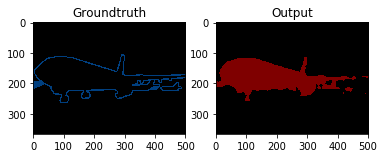

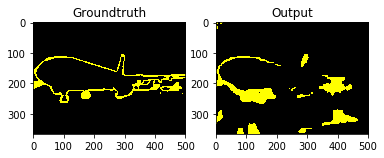

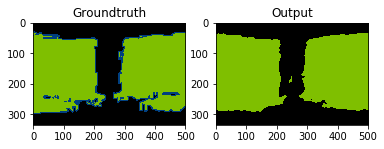

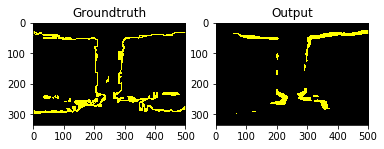

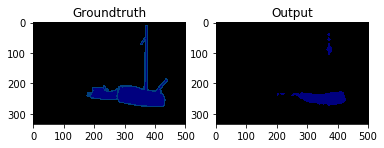

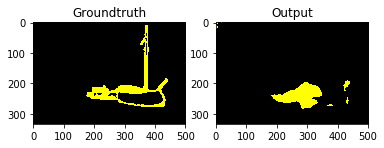

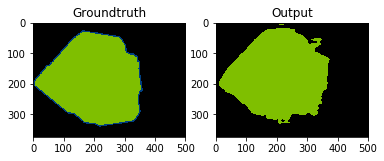

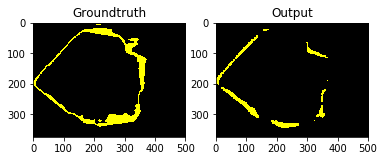

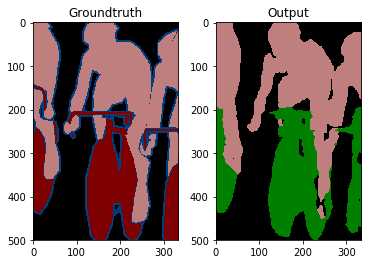

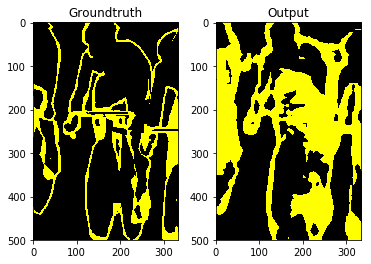

100 processd
200 processd
300 processd
400 processd
500 processd
600 processd
700 processd
800 processd
900 processd
1000 processd
1100 processd
1200 processd
1300 processd
1400 processd
meanIOU for intermediate network: 0.42438395026155595
meanIOU: 0.7270153616621434



In [9]:
# EVALUATION - student and supervisors
def eval():
    """Create the model and start the evaluation process."""
    args = get_arguments()

    gpu0 = args.gpu

    model = Res_Deeplab(num_classes=args.num_classes)
    
    saved_state_dict = torch.load(args.restore_from)
    
    #Load the trained supervisor parameters here:
    int_saved_state_dict = torch.load('./Int_Snapshots/Binary_Error/REFLECT_PADDING/class_dependant/Lay100_BINARY_CLASS_DEPENDANT10000')
    
    '''#Loading and removing extra term infront of layer names if neccessary
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in saved_state_dict.items():
        name = k[6:] # remove `module.`
        new_state_dict[name] = v
    # load params
    model.load_state_dict(new_state_dict)'''
    
    model.load_state_dict(saved_state_dict)
    
    model.eval()
    model.cuda(gpu0)
    layer = 99     #THIS DEFINES THE LAYER THAT THE SUPERVISOR GRABS ACTIVATIONS FROM
    
    
    int_model = Decoder_Binary(input_size_list[layer])
    #int_model = Decoder_Binary_weighting(input_size_list[layer], num_classes= NUM_CLASSES)
    #int_model = Decoder_Multiclass_Weighting(input_size_list[layer], num_classes = NUM_CLASSES)
    
    
    int_model.load_state_dict(int_saved_state_dict)
    int_model.eval()
    int_model.cuda(gpu0)
    
    VOCDataSet2 = VOCDataSet(args.data_dir,args.data_list, crop_size=(505, 505), mean=IMG_MEAN, scale=False, mirror=False)
    
    testloader = data.DataLoader(VOCDataSet2, batch_size=1, shuffle=False, pin_memory=True)
    
    interp = nn.Upsample(size=(505, 505), mode='bilinear', align_corners=True)
    
    data_list = []
    int_data_list = []
    iou_list = []
    confidence_list = []
    DL_iou_list = []
    
    for index, batch in enumerate(testloader):
        if index % 100 == 0:
            print('%d processd'%(index))
        image, label, size, name = batch 
        size = size[0].numpy()
        
        global activations
        activations = []
        
        output = model(Variable(image).cuda(gpu0))
        
        image = Variable(image).cuda(gpu0)

        output = interp(output).cpu().data[0].numpy()
 
        
        int_output_list = []
        
    
        channel_size = activations[layer].size()[1]
            
        int_output = int_model(activations[layer])
        
        int_output = interp(int_output).cpu().data[0].numpy()

        
        int_output = int_output[:,:size[0],:size[1]]
        int_output = int_output.transpose(1,2,0)
        int_output = np.asarray(np.argmax(int_output, axis=2), dtype=np.int)
                    
        int_output_list.append(int_output)
            
        output = output[:,:size[0],:size[1]]
        
        gt = np.asarray(label[0].numpy()[:size[0],:size[1]], dtype=np.int)
        
        output = output.transpose(1,2,0)
        output = np.asarray(np.argmax(output, axis=2), dtype=np.int)
        
        #int_gt = binary_gt_convert(output, gt)   #Class Independant
        int_gt = class_gt_convert(output, gt)    #Class Dependant
        #int_gt = class_out_gt_convert(output, gt)   #Multiclass
 
        
        if index < 5:
            show_all(gt, output)
            #show_all(int_gt, int_output)
            show_all_binary(int_gt, int_output)        #Uncomment to show the first 50 image outputs for both the student & supervisor
            
        
        data_list.append([gt.flatten(), output.flatten()])
 
        confidence_list.append(confidence_score(int_output_list[0], int_gt))
        
        #print(binary_IOU(int_output, int_gt))                  #Binary IOU
        #iou_list.append(multiclass_IOU(int_output, int_gt))    #Multi-class IOU
        
        iou_list.append(binary_IOU(int_output, int_gt))
        
    print("meanIOU for intermediate network:", sum(iou_list)/float(len(iou_list)))
    get_iou(data_list, args.num_classes)

main()

# -> VOC20000 mIOU = 0.736433 (0-padding)   ||    0.727015 (reflect padding)